# Creating a General Purpose Potential for Molecular Crystals - Part 8

This notebook is used to create a general purpose GAP potential for molecular crystals. The potential is built on PBE-D2 data from short PIMD simulations of 2238 different molecular crystals. Please note that it has a high (~150 GB) memory requirement to run fully.

In this part of the notebook: 
- Create a direct model using the exact same parameters as were used for the improved delta model

### Import modules, functions, and necessary raw data from parts 1, 2 and 3

In [1]:
#Import modules
from matplotlib import pylab as plt
from tqdm import tqdm
import itertools
from joblib import Parallel, delayed, parallel_backend

import pickle
import numpy as np
from numpy.random import RandomState
random_state = RandomState(0)
from sklearn import linear_model
import skcosmo.feature_selection
#from skcosmo.feature_selection import FPS
from skcosmo.sample_selection import PCovCUR, FPS
from skcosmo.preprocessing import StandardFlexibleScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, callbacks, dump, load
from skopt.callbacks import CheckpointSaver
from skopt.plots import plot_convergence, plot_objective

import ase
from ase.io import read, write
from ase.build import make_supercell
from ase.visualize import view
import numpy as np
# If installed -- not essential, though
try:
    from tqdm.notebook import tqdm
except ImportError:
    tqdm = (lambda i, **kwargs: i)

from time import time, sleep

from rascal.models import KRR
from rascal.utils import dump_obj, load_obj

from rascal.models import Kernel, train_gap_model, compute_KNM
from rascal.representations import SphericalInvariants
from rascal.neighbourlist.structure_manager import mask_center_atoms_by_species
from rascal.representations.spherical_invariants import get_power_spectrum_index_mapping
from rascal.utils import from_dict, to_dict, CURFilter, FPSFilter, dump_obj, load_obj
from rascal.utils import get_score, get_optimal_radial_basis_hypers
from rascal.utils.io import load_json, dump_json

In [2]:
#Define functions
def do_fps(x, d=0):
    """
    Function for performing farthest-point-sampling for a given feature matrix.
    d gives the number of farthest-point-sampled feature vectors that will be outputted. 
    If d==0, the entire set will be FPS-sorted.
    Returns the FPS-sorted IDs, as well as the FPS distances.
    """
    if d == 0 : d = len(x)
    n = len(x)
    iy = np.zeros(d, int)
    # faster evaluation of Euclidean distance
    n2 = np.sum(x**2,axis=1)
    iy[0] = 0
    dl = n2 + n2[iy[0]] - 2* np.dot(x, x[iy[0]])
    dss = []
    for i in range(1,d):
        iy[i] = np.argmax(dl)
        nd = n2 + n2[iy[i]] - 2*np.dot(x,x[iy[i]])
        dl = np.minimum(dl, nd)
        dss.append(max(dl))
    return iy,dss

def get_forces(frames, force_array='PBE-D2_forces'):
    frc = np.zeros((np.sum([len(frm) for frm in frames]),3))
    iat = 0
    for ifrm,frm in enumerate(frames):
        frc[iat:iat+len(frm)] = frm.get_array(force_array) 
        iat += len(frm)
    return frc

def get_features(atoms_objects, batch_size=1000, progress_bar=True):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        This requires soap to be set.
    '''
    struct_feat=[] #create empty feature vector of n_structures x n_features
    got_frame = False
    for frm in atoms_objects:
        if got_frame == False: 
            if all(sp in frm.get_atomic_numbers() for sp in [1,6,7,8]) == True:
                all_species = frm
                got_frame = True
    for i in tqdm(range(int(len(atoms_objects)/batch_size+0.9999)), disable = not progress_bar): #Get feature vectors in batches of 1000
        for frm in atoms_objects[i*batch_size:(i+1)*batch_size]:
            frm.wrap(eps=1e-13) #wrap atoms in unit cell
        frames=[all_species.copy()] #add initial frame with all species
        frames.extend(atoms_objects[i*batch_size:(i+1)*batch_size]) #extend initial frame with frames of batch
        manager = soap.transform(frames) #calculate soap features for all structures in batch
        env_feat_batch = manager.get_features(soap)[len(all_species):] #get feature vectors for all structures in batch
        # (having removed the initial frame)
        atom_counter=0 #count atoms
        for ifrm,frm in enumerate(atoms_objects[i*batch_size:(i+1)*batch_size]): #iterate over frames in batch
            nat=len(frm) #count atoms in frame
            struct_feat.append(np.mean(env_feat_batch[atom_counter:atom_counter+nat],axis=0)) #average vectors
            # for atoms in the same frame. Done by averaging vectors between atom_counter and atom_counter + nat
            atom_counter+=nat #add atoms to counter
    struct_feat_array=np.asarray(struct_feat)
    return struct_feat_array

def get_features_parallel(atoms_objects, bsize=1000, n_cores = 4):
    '''Get average feature vectors for each structure in a list of atoms objects. 
        Do this in parallel
    '''
    blocks = []
    for iblk, blk in enumerate(range(0, len(atoms_objects), bsize)):
        blocks.append(atoms_objects[iblk*bsize:(iblk+1)*bsize])
    with parallel_backend(backend="loky"):
        results = Parallel(n_jobs=n_cores)(delayed(get_features)(frames, batch_size=10000, 
                                                                 progress_bar=False) for frames in blocks)

    return np.concatenate(results)

def predict_batched(frames, ml_model):
    man_pred = soap.transform(frames)
    return ml_model.predict(man_pred)

In [40]:
#Import raw data
train_set = np.load('raw_data/CSD-10k_train_set.npy', allow_pickle=True)
val_set = np.load('raw_data/CSD-10k_val_set.npy', allow_pickle=True)
test_set = np.load('raw_data/CSD-10k_test_set.npy', allow_pickle=True)
X_train = np.load('raw_data/X_train.npy') 
y_train = np.load('raw_data/y_train.npy')
X_val = np.load('raw_data/X_val.npy') 
y_val = np.load('raw_data/y_val.npy')
X_test = np.load('raw_data/X_test.npy') 
y_test = np.load('raw_data/y_test.npy')
X_train_fps = np.load('raw_data/X_train_fps.npy')
y_train_fps = np.load('raw_data/y_train_fps.npy')
fps_ids = np.load('raw_data/CSD-10k_train_set_FPS_ids.npy')
fps_dist = np.load('raw_data/CSD-10k_train_set_FPS_dist.npy')
with open('raw_data/mlr.pkl', 'rb') as mlr_file:
    mlr = pickle.load(mlr_file)
initial_train_set = np.load('raw_data/initial_train_set_4pc.npy', allow_pickle=True)
train_set_FPS = np.load('model_data/train_set_FPS.npy', allow_pickle=True)
with open('raw_data/CSD-1k_hcno_w_DFTB.pickle', 'rb') as f:
    csd_1k = pickle.load(f)

/home/vprincip/code/miniconda3/envs/genshift/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Ridge from version 1.1.0rc1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
#Define hyperparameters and SOAP
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False 
              )
soap = SphericalInvariants(**hypers) #redefine soap with new parameters

## Reload database with DFTB+ results

In [6]:
#(Re-)Open dataset
with open('delta_data/CSD-10k_combined_w_kpts_11_pc_w_DFTB.pickle', 'rb') as f:
    db = pickle.load(f)

In [7]:
#Add energy and force deltas to frame
for name in db.keys():
    for frm in db[name]:
        frm.info['Delta_energy'] = frm.info['PBE-D2_energy'] - frm.info['DFTB_energy']
        frm.arrays['Delta_forces'] = frm.arrays['PBE-D2_forces'] - frm.arrays['DFTB_forces']

## Create training, validation and test sets

In [41]:
#Create training and val sets
all_frames = []
for name in db.keys():
    for frm in db[name]:
        all_frames.append(frm)

ids = np.arange(len(all_frames))
np.random.seed(10)
np.random.shuffle(ids)

train_frames = [all_frames[i] for i in ids[1000:]]
val_frames = [all_frames[i] for i in ids[:1000]]

In [51]:
#Create composition (X), energy deltas (y) and force deltas (f) arrays
X_all = np.zeros((len(all_frames), 4), dtype=int) ; y_all = np.zeros(len(all_frames), dtype=float)
f_all = np.zeros((np.sum([len(frm) for frm in all_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(all_frames):
    symbols = frm.get_atomic_numbers()
    X_all[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_all[ifrm] = frm.info['PBE-D2_energy']
    f_all[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)
    
X_train = np.zeros((len(train_frames), 4), dtype=int) ; y_train = np.zeros(len(train_frames), dtype=float)
f_train = np.zeros((np.sum([len(frm) for frm in train_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(train_frames):
    symbols = frm.get_atomic_numbers()
    X_train[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_train[ifrm] = frm.info['PBE-D2_energy']
    f_train[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)

X_val = np.zeros((len(val_frames), 4), dtype=int) ; y_val = np.zeros(len(val_frames), dtype=float)
f_val = np.zeros((np.sum([len(frm) for frm in val_frames]),3), dtype=float)

counter = 0
for ifrm, frm in enumerate(val_frames):
    symbols = frm.get_atomic_numbers()
    X_val[ifrm] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    y_val[ifrm] = frm.info['PBE-D2_energy']
    f_val[counter:counter+len(frm)] = frm.arrays['PBE-D2_forces']
    counter += len(frm)

In [43]:
X_test = np.zeros((len(csd_1k), 4), dtype=int); y_test = np.zeros(len(csd_1k), dtype=float)
f_test = np.zeros((sum([len(frm) for frm in csd_1k]),3), dtype=float)

force_counter=0
for ifrm, frm in enumerate(csd_1k):
    X_test[ifrm] = [len(np.where(frm.get_atomic_numbers() == sp)[0]) for sp in [1,6,7,8]]
    y_test[ifrm] = frm.info['PBE-D2_energy']
    for iforces, forces in enumerate(frm.arrays['PBE-D2_forces']):
        f_test[force_counter] = forces
        force_counter += 1

In [10]:
#Create baselined per-atom energy model
mlr = Ridge(fit_intercept=False, alpha=1e-4)
mlr.fit(X_all, y_all)
for spec, coef in zip(['H', 'C', 'N', 'O'], mlr.coef_):
    print(f"Per-atom energy for species {spec} : {coef} eV")

Per-atom energy for species H : -16.468153332304215 eV
Per-atom energy for species C : -154.72001091746486 eV
Per-atom energy for species N : -383.34420755813 eV
Per-atom energy for species O : -566.227034198853 eV


In [11]:
#get dressed atom energies for reduced training set
y_dressed = {}
for i,j in enumerate([1,6,7,8]):
    y_dressed[j] = mlr.coef_[i]

## Get PCovFPS Sample and Feature IDs

In [12]:
#Reload PCovFPS-sorted sample IDs
pcf_ids = np.load('delta_data/pcovfps_selected_idx.npy')

In [13]:
#Reload PCovFPS-sorted sample IDs
pcf_feat_ids = np.load('delta_data/pcovfps_features_selected_idx.npy')

## Create Model

In [14]:
#Define soap hyperparameters
zeta=3
hypers = dict(soap_type="PowerSpectrum",
              interaction_cutoff=6, #cutoff distance in angstroms
              max_radial=9, #no. of radial basis functions
              max_angular=6, #no. of angular basis functions
              gaussian_sigma_constant=0.4, #sigma width (i.e. amount of 'smearing')
              gaussian_sigma_type="Constant",
              cutoff_function_type="RadialScaling",
              cutoff_smooth_width=0.5,
              cutoff_function_parameters=
                    dict(
                            rate=1,
                            scale=2,
                            exponent=4
                        ),
              radial_basis="GTO",
              normalize=True,
              optimization=
                    dict(
                            Spline=dict(
                               accuracy=1.0e-05
                            )
                        ),
              compute_gradients=False #don't care about forces right now
              )
soap = SphericalInvariants(**hypers)

In [15]:
#Figure out which indices are mapped to which features
sp_pairs = soap.get_keys([1, 6, 7, 8])
mapping = get_power_spectrum_index_mapping(
    sp_pairs, n_max=hypers["max_radial"], l_max=hypers["max_angular"]+1 
) # +1 in lmax needed because of some Librascal bug (Rose said)

In [16]:
#Tell soap to only use indices from PCovFPS sorting
n_feats = 2500 #use this number of features (determined from the feature optimisation)
a = [mapping[i]['a'] for i in pcf_feat_ids[:n_feats]]
b = [mapping[i]['b'] for i in pcf_feat_ids[:n_feats]]
n1 = [mapping[i]['n1'] for i in pcf_feat_ids[:n_feats]]
n2 = [mapping[i]['n2'] for i in pcf_feat_ids[:n_feats]]
l = [mapping[i]['l'] for i in pcf_feat_ids[:n_feats]]

hypers['coefficient_subselection'] = {"a": a, "b": b, "n1": n1, "n2":n2, "l":l}
soap = SphericalInvariants(**hypers)
#soap = SphericalInvariants(**hypers, coefficient_subselection={"a": a, "b": b, "n1": n1, "n2":n2, "l":l})

In [17]:
#Create PCov-FPS sorted training database
n_train = 15000 #choose (optimal) number of training structures
pcf_train_frames = []; pcf_X_train=np.zeros((n_train, 4)); pcf_y_train=np.zeros(n_train); 

for ii, i in enumerate(pcf_ids[:n_train]):
    frm = train_frames[i]
    pcf_train_frames.append(frm)
    symbols = frm.get_atomic_numbers()
    pcf_X_train[ii] = [len(np.where(symbols == sp)[0]) for sp in [1,6,7,8]]
    pcf_y_train[ii] = frm.info['PBE-D2_energy']

pcf_yred_train = pcf_y_train/np.sum(pcf_X_train,axis=1)-mlr.predict(pcf_X_train)/np.sum(pcf_X_train,axis=1)

In [19]:
# Compute feature matrices
print("Computing feature matrices...")
start=time()
manager_train = soap.transform(pcf_train_frames) #calculating features
print("Time taken: ", time()-start, "s")

Computing feature matrices...
Time taken:  249.74068760871887 s


In [20]:
# Use an FPS filter to obtain desired number of sparse points per species
nh = 2000
nc = 2000
nn = 2000
no = 2000
nsparse    = {1: nh, 6: nc, 7: nn, 8: no} #Select number of sparse environemnts per species
compressor = FPSFilter(soap,nsparse,act_on='sample per species') #Filter to sparsify full feature matrix
print("Sparsifying training set...")
start=time()
X_sparse = compressor.select_and_filter(manager_train) #Apply filter to training set
print("Time taken: ", time()-start, "s")

Sparsifying training set...
Time taken:  499.0923128128052 s


In [21]:
dump_obj('raw_data/X_sparse_15k_d_params.json', X_sparse)

In [ ]:
X_sparse = load_obj('delta_data/X_sparse_15k_d_params.json')

In [22]:
#Define kernel and redefine hypers 
hypers["compute_gradients"] = True #we want to compute gradients (forces) for the kernel
soap = SphericalInvariants(**hypers)
kernel = Kernel(soap, name='GAP', zeta=zeta, target_type='Structure', kernel_type='Sparse') #Define Kernel

In [23]:
#Compute kernel
start=time()
Knm = compute_KNM(tqdm(pcf_train_frames, desc="Compute KNM", leave=False), X_sparse, kernel, soap)
print("Time taken: ", time()-start, "s")

Compute KNM:   0%|          | 0/15000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Time taken:  105112.39661693573 s


In [24]:
#Save kernel
np.save('raw_data/Knm_kernel_15k_d_params', Knm)

In [68]:
start = time()
print("Loading Knm...")
Knm = np.load('raw_data/Knm_kernel_15k_d_params.npy')
print("Knm loading time:", time()-start, "s")

Loading Knm...
Knm loading time: 1906.5201878547668 s


In [25]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, pcf_train_frames, Knm, X_sparse, pcf_y_train, y_dressed, 
                             grad_train=-get_forces(pcf_train_frames), lambdas=[0.046416,1.160397], 
                             jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 607.10063123703


In [75]:
#Save model
dump_obj('raw_data/GAP_model_15k_d_params_0.046_1.16.json', full_model)

## Test Model on Validation Set

In [54]:
#predict energies and forces for validation set
npred=1000
ytp = []
ftp = []

for frm in tqdm(val_frames[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

yval_pred = np.array(ytp).flatten()
fval_pred = np.concatenate(ftp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [65]:
#Save results
np.save('predictions/yval_pred_15k_d_params_0.046_1.16', yval_pred)
np.save('predictions/fval_pred_15k_d_params_0.046_1.16', fval_pred)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

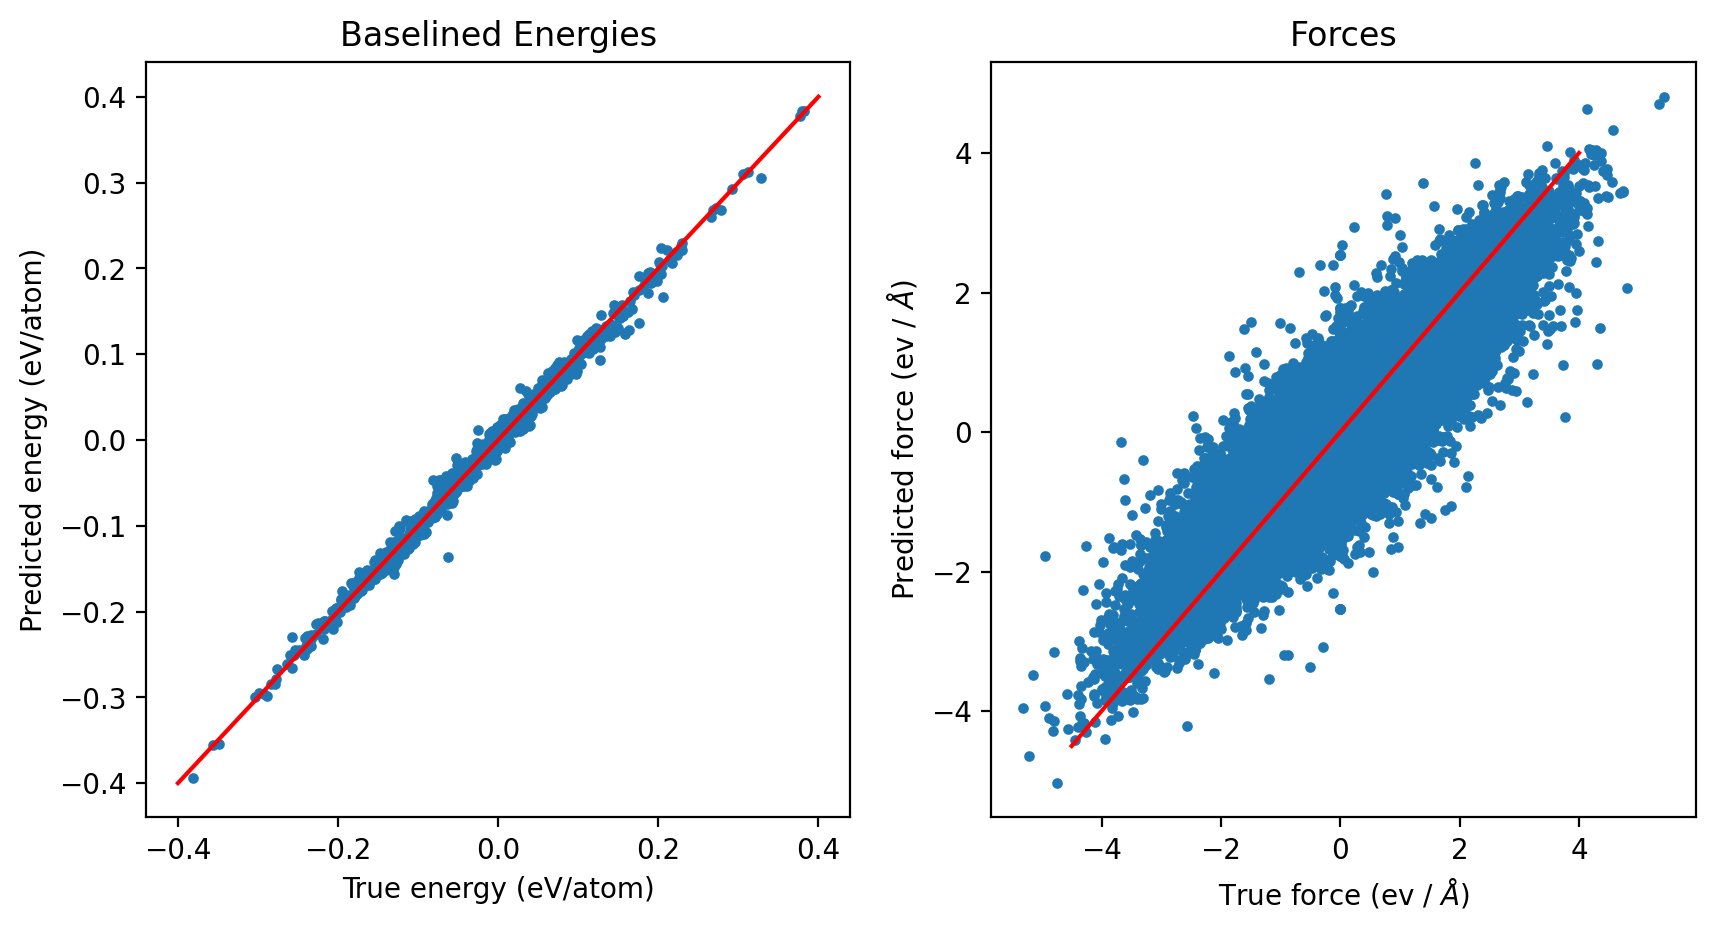

In [57]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_val.flatten(), fval_pred.flatten(), s=8)
p[1].plot([-4.5,4],[-4.5, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
#plt.savefig('figures/val_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [58]:
rmse_energy = np.sqrt(np.mean(
    ((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
     - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [59]:
rmse_forces = np.sqrt(np.mean((f_val.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [60]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  9.06123 meV/atom
RMSE forces:  309.47999999999996 meV/Angstrom


## Test Model on Test Set

In [61]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(csd_1k[:npred], desc = "Making predictions for true test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for true test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [64]:
#Save results
np.save('predictions/ytest_pred_15k_d_params_0.046_1.16', ytest_pred)
np.save('predictions/ftest_pred_15k_d_params_0.046_1.16', ftest_pred)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

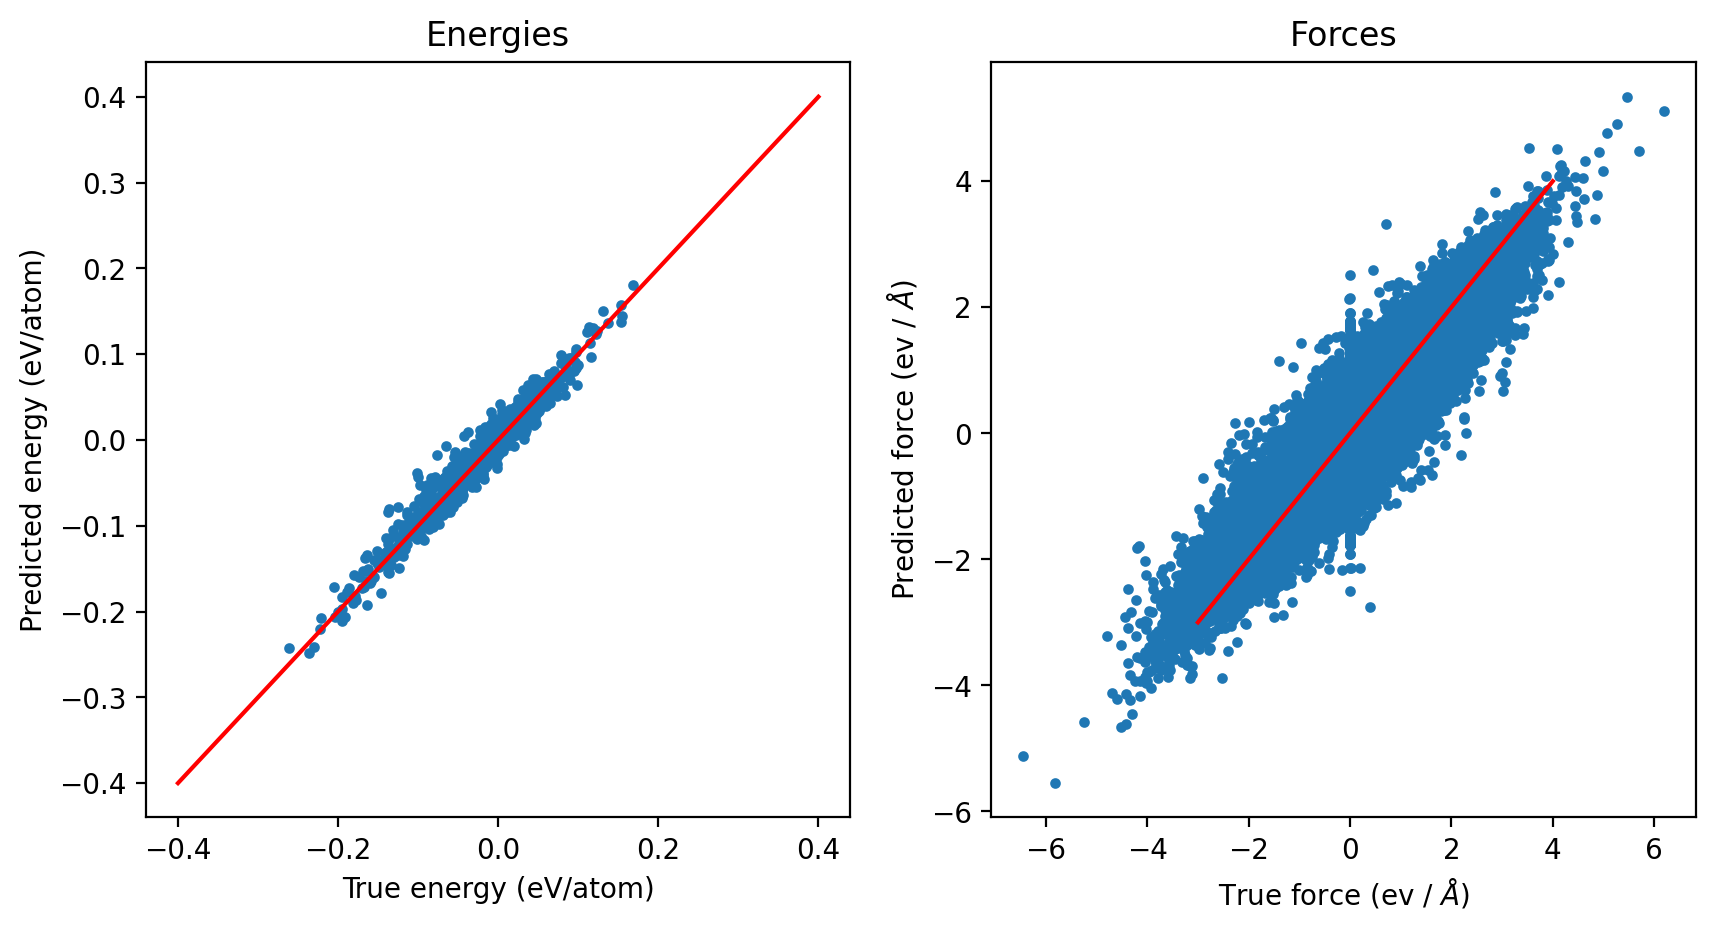

In [62]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_test.flatten(), ftest_pred.flatten(), s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
#plt.savefig('figures/true_test_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [67]:
rmse_energy = np.sqrt(np.mean(
    ((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
     - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))

In [68]:
rmse_forces = np.sqrt(np.mean((f_test.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [69]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  13.45931 meV/atom
RMSE forces:  219.65 meV/Angstrom


## Plot both test set and val set

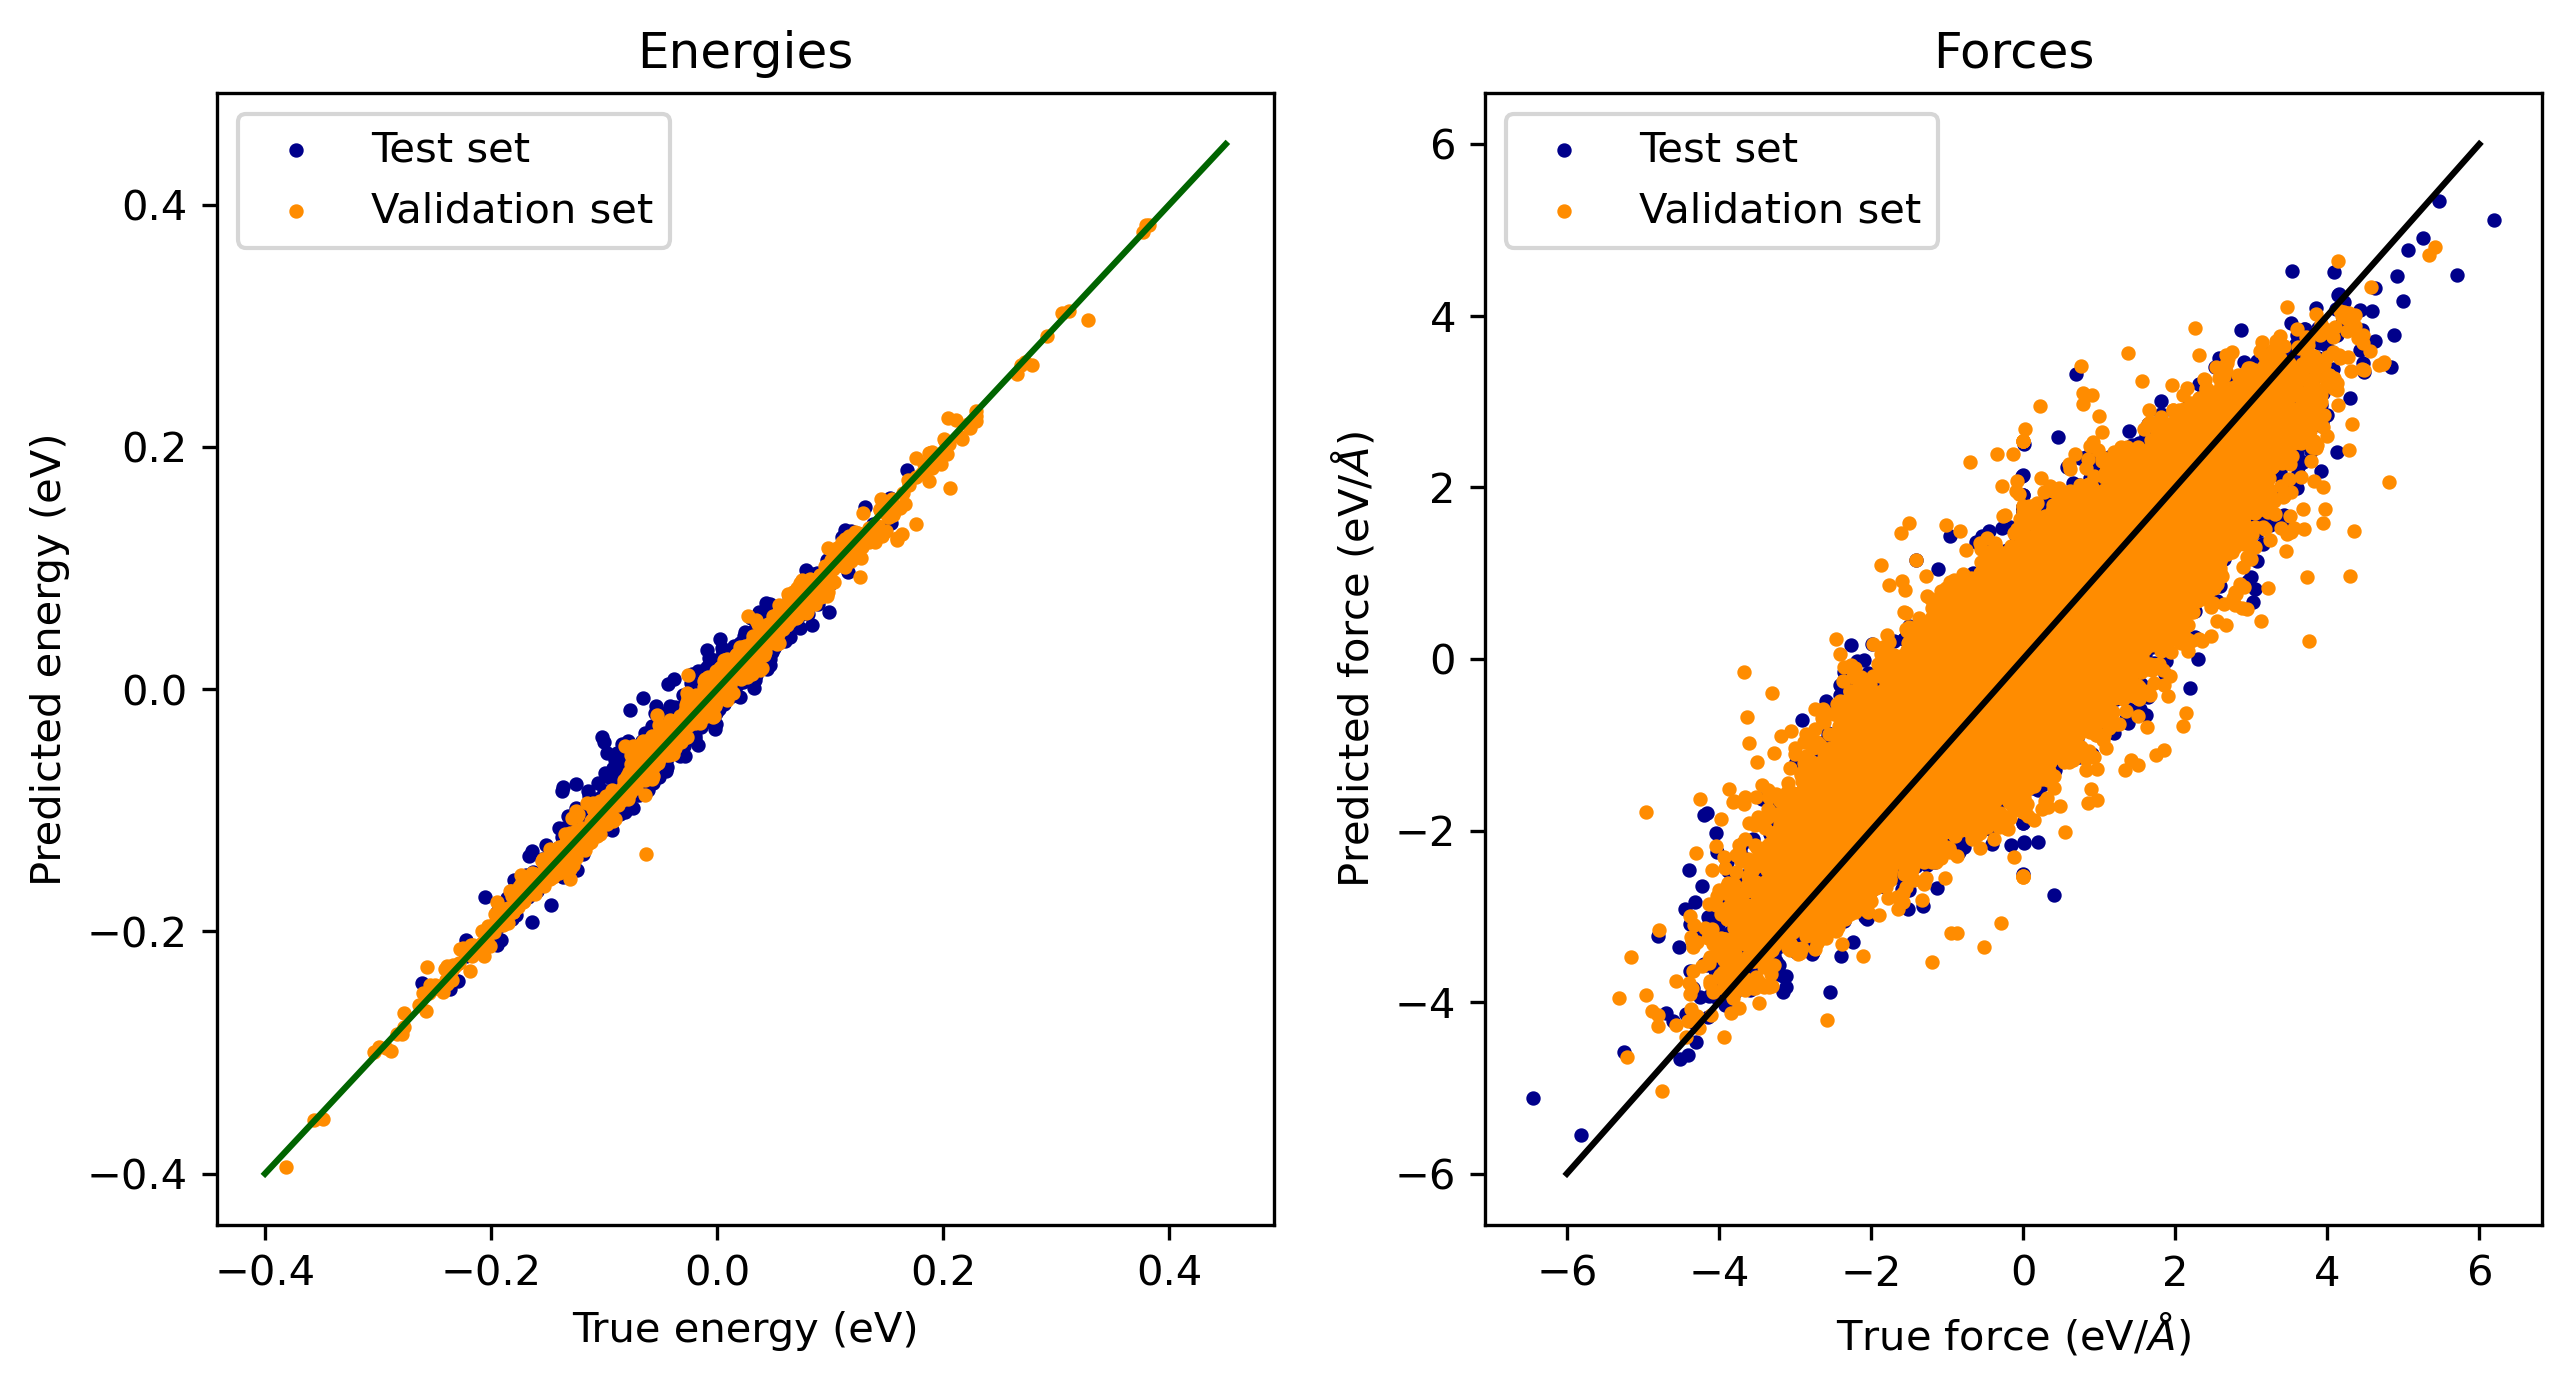

In [71]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=300)
p[0].scatter((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), 
             s=6, color='darkblue', alpha=1, label='Test set')
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), 
             s=6, color='darkorange', alpha=1, label='Validation set')
p[0].set_title('Energies')
p[0].plot([-0.4,0.45], [-0.4, 0.45], color='darkgreen')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[0].legend()
p[1].scatter(f_test.flatten(), ftest_pred.flatten(), s=6, color='darkblue', alpha=1, label='Test set')
p[1].scatter(f_val.flatten(), fval_pred.flatten(), s=6, color='darkorange', alpha=1, label='Validation set')
p[1].plot([-6,6], [-6, 6], color='black')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (eV/$\AA$)')
p[1].set_ylabel('Predicted force (eV/$\AA$)')
p[1].legend()
plt.savefig('figures/direct_model_test_val_set_comparison_model_15k_d_params_0.02_2.png')

## Create model with 0.02 and 2 regularisers
These were the regularisers used for the plots that were added to the thesis proposal

In [76]:
#Train GAP model
print("Training GAP model...")
start = time()
full_model = train_gap_model(kernel, pcf_train_frames, Knm, X_sparse, pcf_y_train, y_dressed, 
                             grad_train=-get_forces(pcf_train_frames), lambdas=[0.02,2], 
                             jitter=1e-9, solver = 'RKHS')
print("Time taken:", time()-start)

Training GAP model...
Time taken: 598.4072937965393


In [77]:
#Save model
dump_obj('raw_data/GAP_model_15k_d_params_0.02_2.json', full_model)

### Test Model on Validation Set

In [82]:
#predict energies and forces for validation set
npred=1000
ytp = []
ftp = []

for frm in tqdm(val_frames[:npred], desc = "Making predictions for validation set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

yval_pred = np.array(ytp).flatten()
fval_pred = np.concatenate(ftp)

Making predictions for validation set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [83]:
#Save results
np.save('predictions/yval_pred_15k_d_params_0.02_2', yval_pred)
np.save('predictions/fval_pred_15k_d_params_0.02_2', fval_pred)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

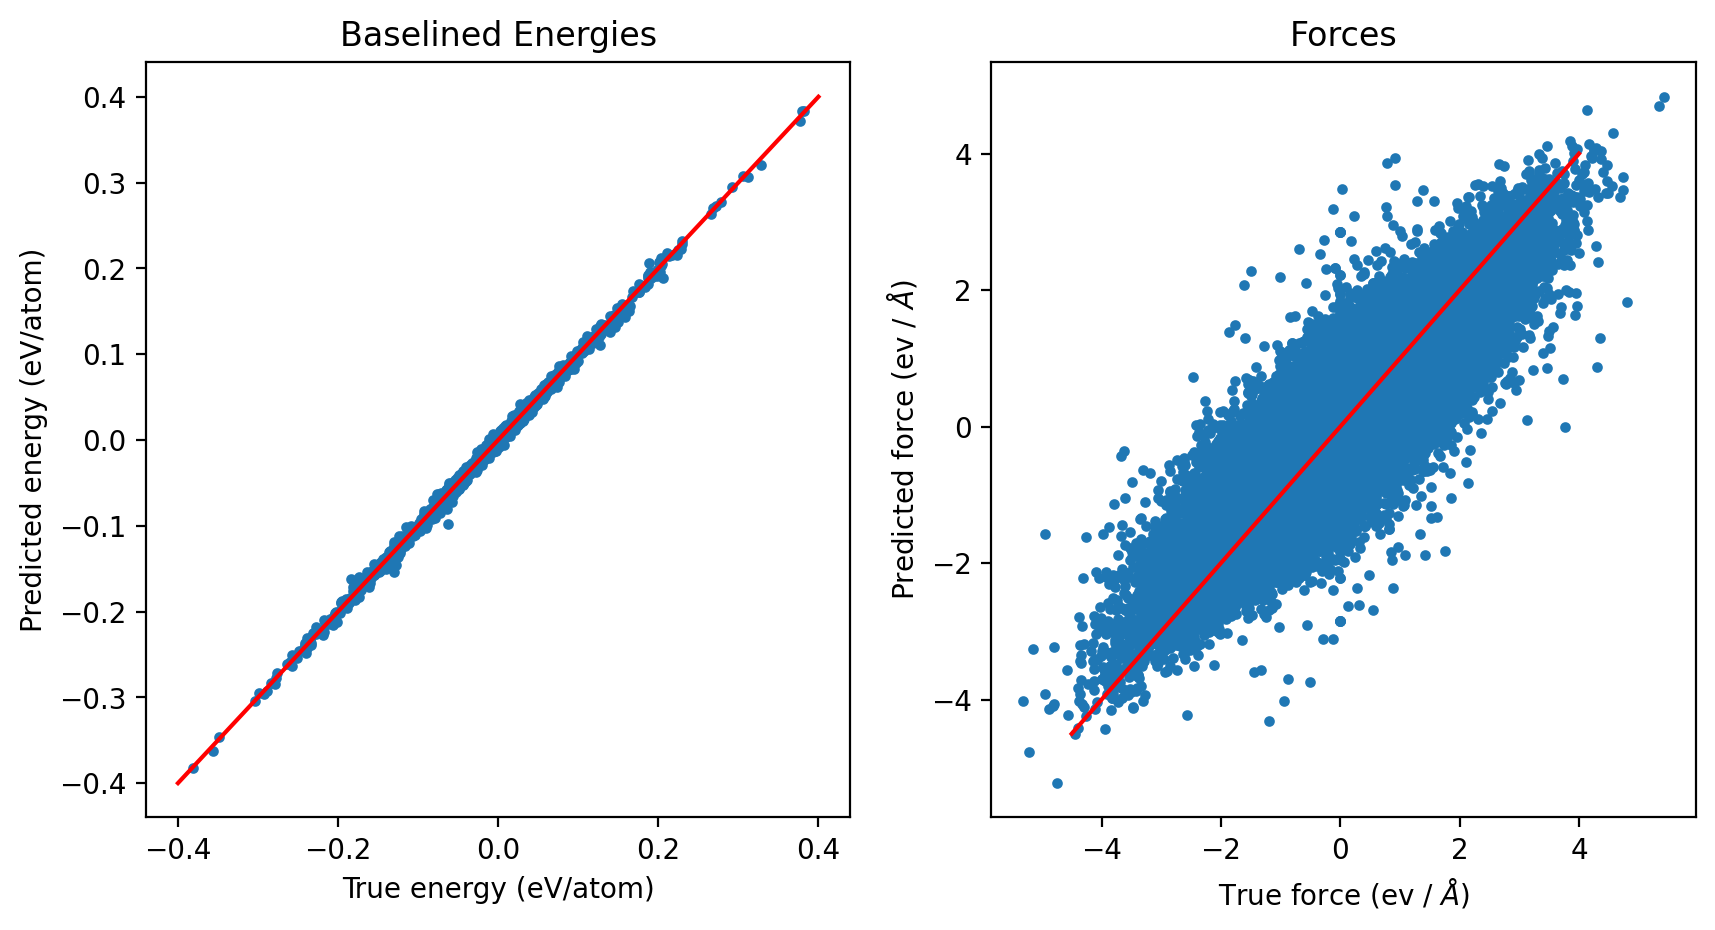

In [84]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Baselined Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_val.flatten(), fval_pred.flatten(), s=8)
p[1].plot([-4.5,4],[-4.5, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
#plt.savefig('figures/val_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [85]:
rmse_energy = np.sqrt(np.mean(
    ((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1) 
     - (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1))**2))

In [86]:
rmse_forces = np.sqrt(np.mean((f_val.flatten()[:npred] - fval_pred.flatten()[:npred])**2))

In [87]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  5.116 meV/atom
RMSE forces:  335.52 meV/Angstrom


### Test Model on Test Set

In [88]:
#predict energies and forces for test set
npred=1000
ytp = []
ftp = []

for frm in tqdm(csd_1k[:npred], desc = "Making predictions for true test set...", leave=False):
    manager_test = soap.transform(frm)
    ytp.append(full_model.predict(manager_test))
    ftp.append(full_model.predict_forces(manager_test))

ytest_pred = np.array(ytp).flatten()
ftest_pred = np.concatenate(ftp)

Making predictions for true test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

In [89]:
#Save results
np.save('predictions/ytest_pred_15k_d_params_0.02_2', ytest_pred)
np.save('predictions/ftest_pred_15k_d_params_0.02_2', ftest_pred)

Text(0, 0.5, 'Predicted force (ev / $\\AA$)')

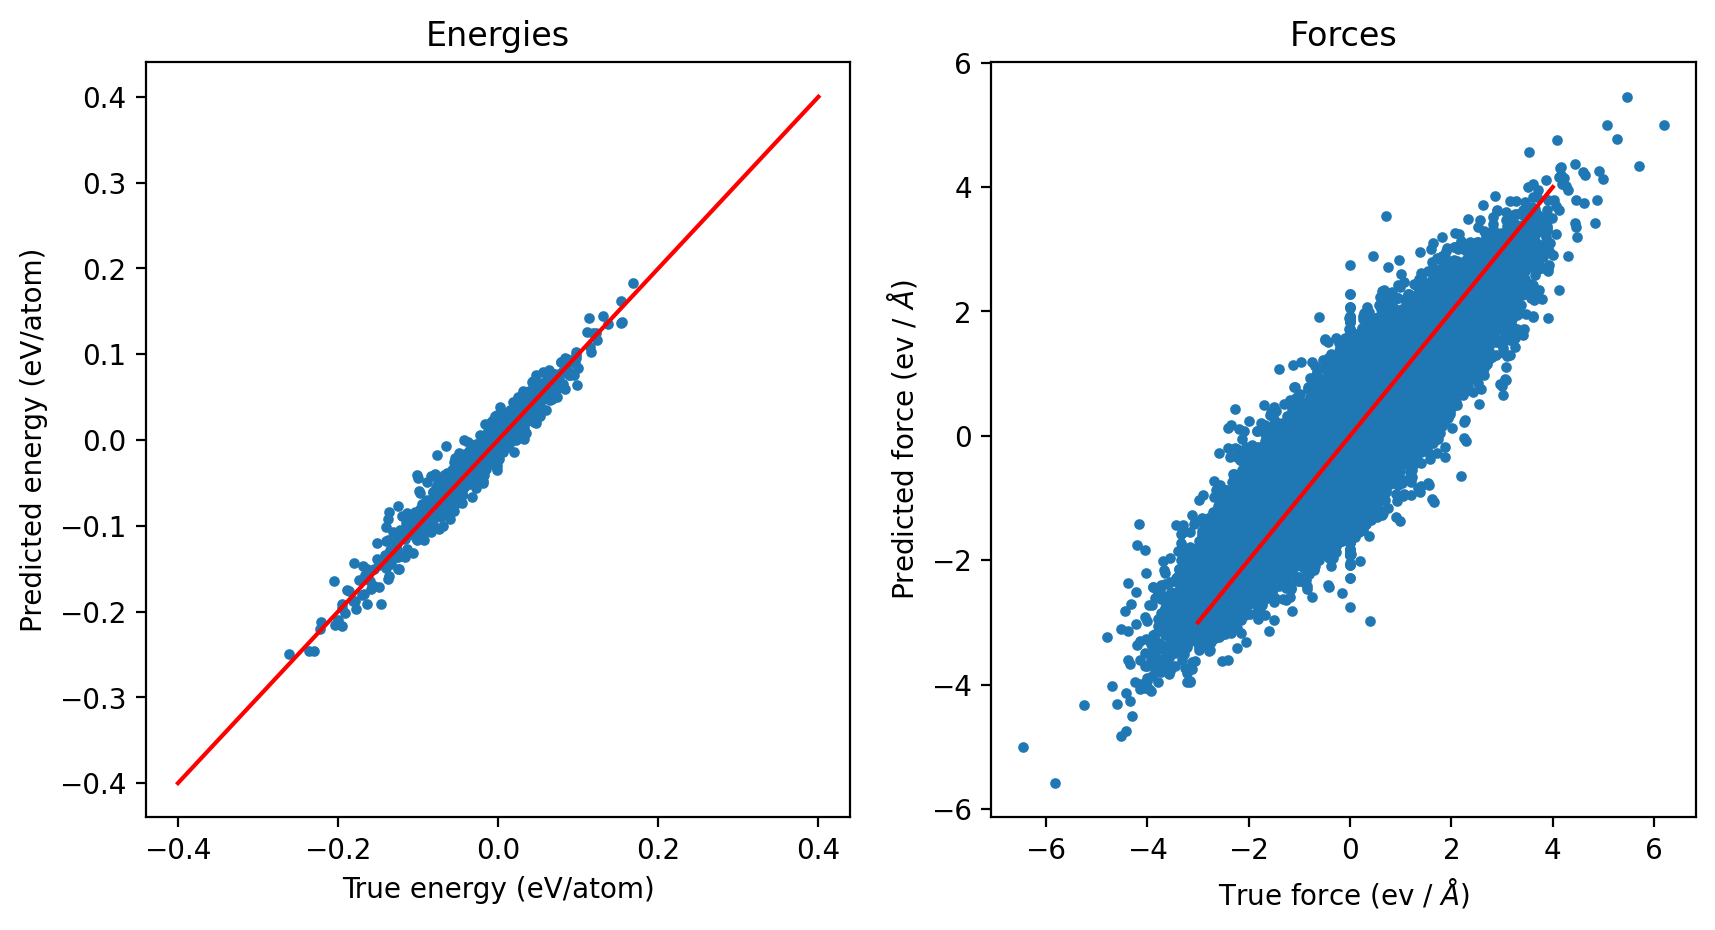

In [90]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=200)
p[0].scatter((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), s=8)
p[0].plot([-0.4,0.4],[-0.4, 0.4], color='red')
p[0].set_title(r'Energies')
p[0].set_xlabel('True energy (eV/atom)')
p[0].set_ylabel('Predicted energy (eV/atom)')
p[1].scatter(f_test.flatten(), ftest_pred.flatten(), s=8)
p[1].plot([-3,4],[-3, 4], color='red')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (ev / $\AA$)')
p[1].set_ylabel('Predicted force (ev / $\AA$)')
#plt.savefig('figures/true_test_set_direct_full_GAP_model_FPS_0.055_3.25.png')

In [91]:
rmse_energy = np.sqrt(np.mean(
    ((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1) 
     - (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1))**2))

In [92]:
rmse_forces = np.sqrt(np.mean((f_test.flatten()[:npred] - ftest_pred.flatten()[:npred])**2))

In [93]:
print("RMSE energy: ", np.round(rmse_energy, 8)*1000, "meV/atom")
print("RMSE forces: ", np.round(rmse_forces, 5)*1000, "meV/Angstrom")

RMSE energy:  13.76192 meV/atom
RMSE forces:  258.03 meV/Angstrom


### Plot both test set and val set

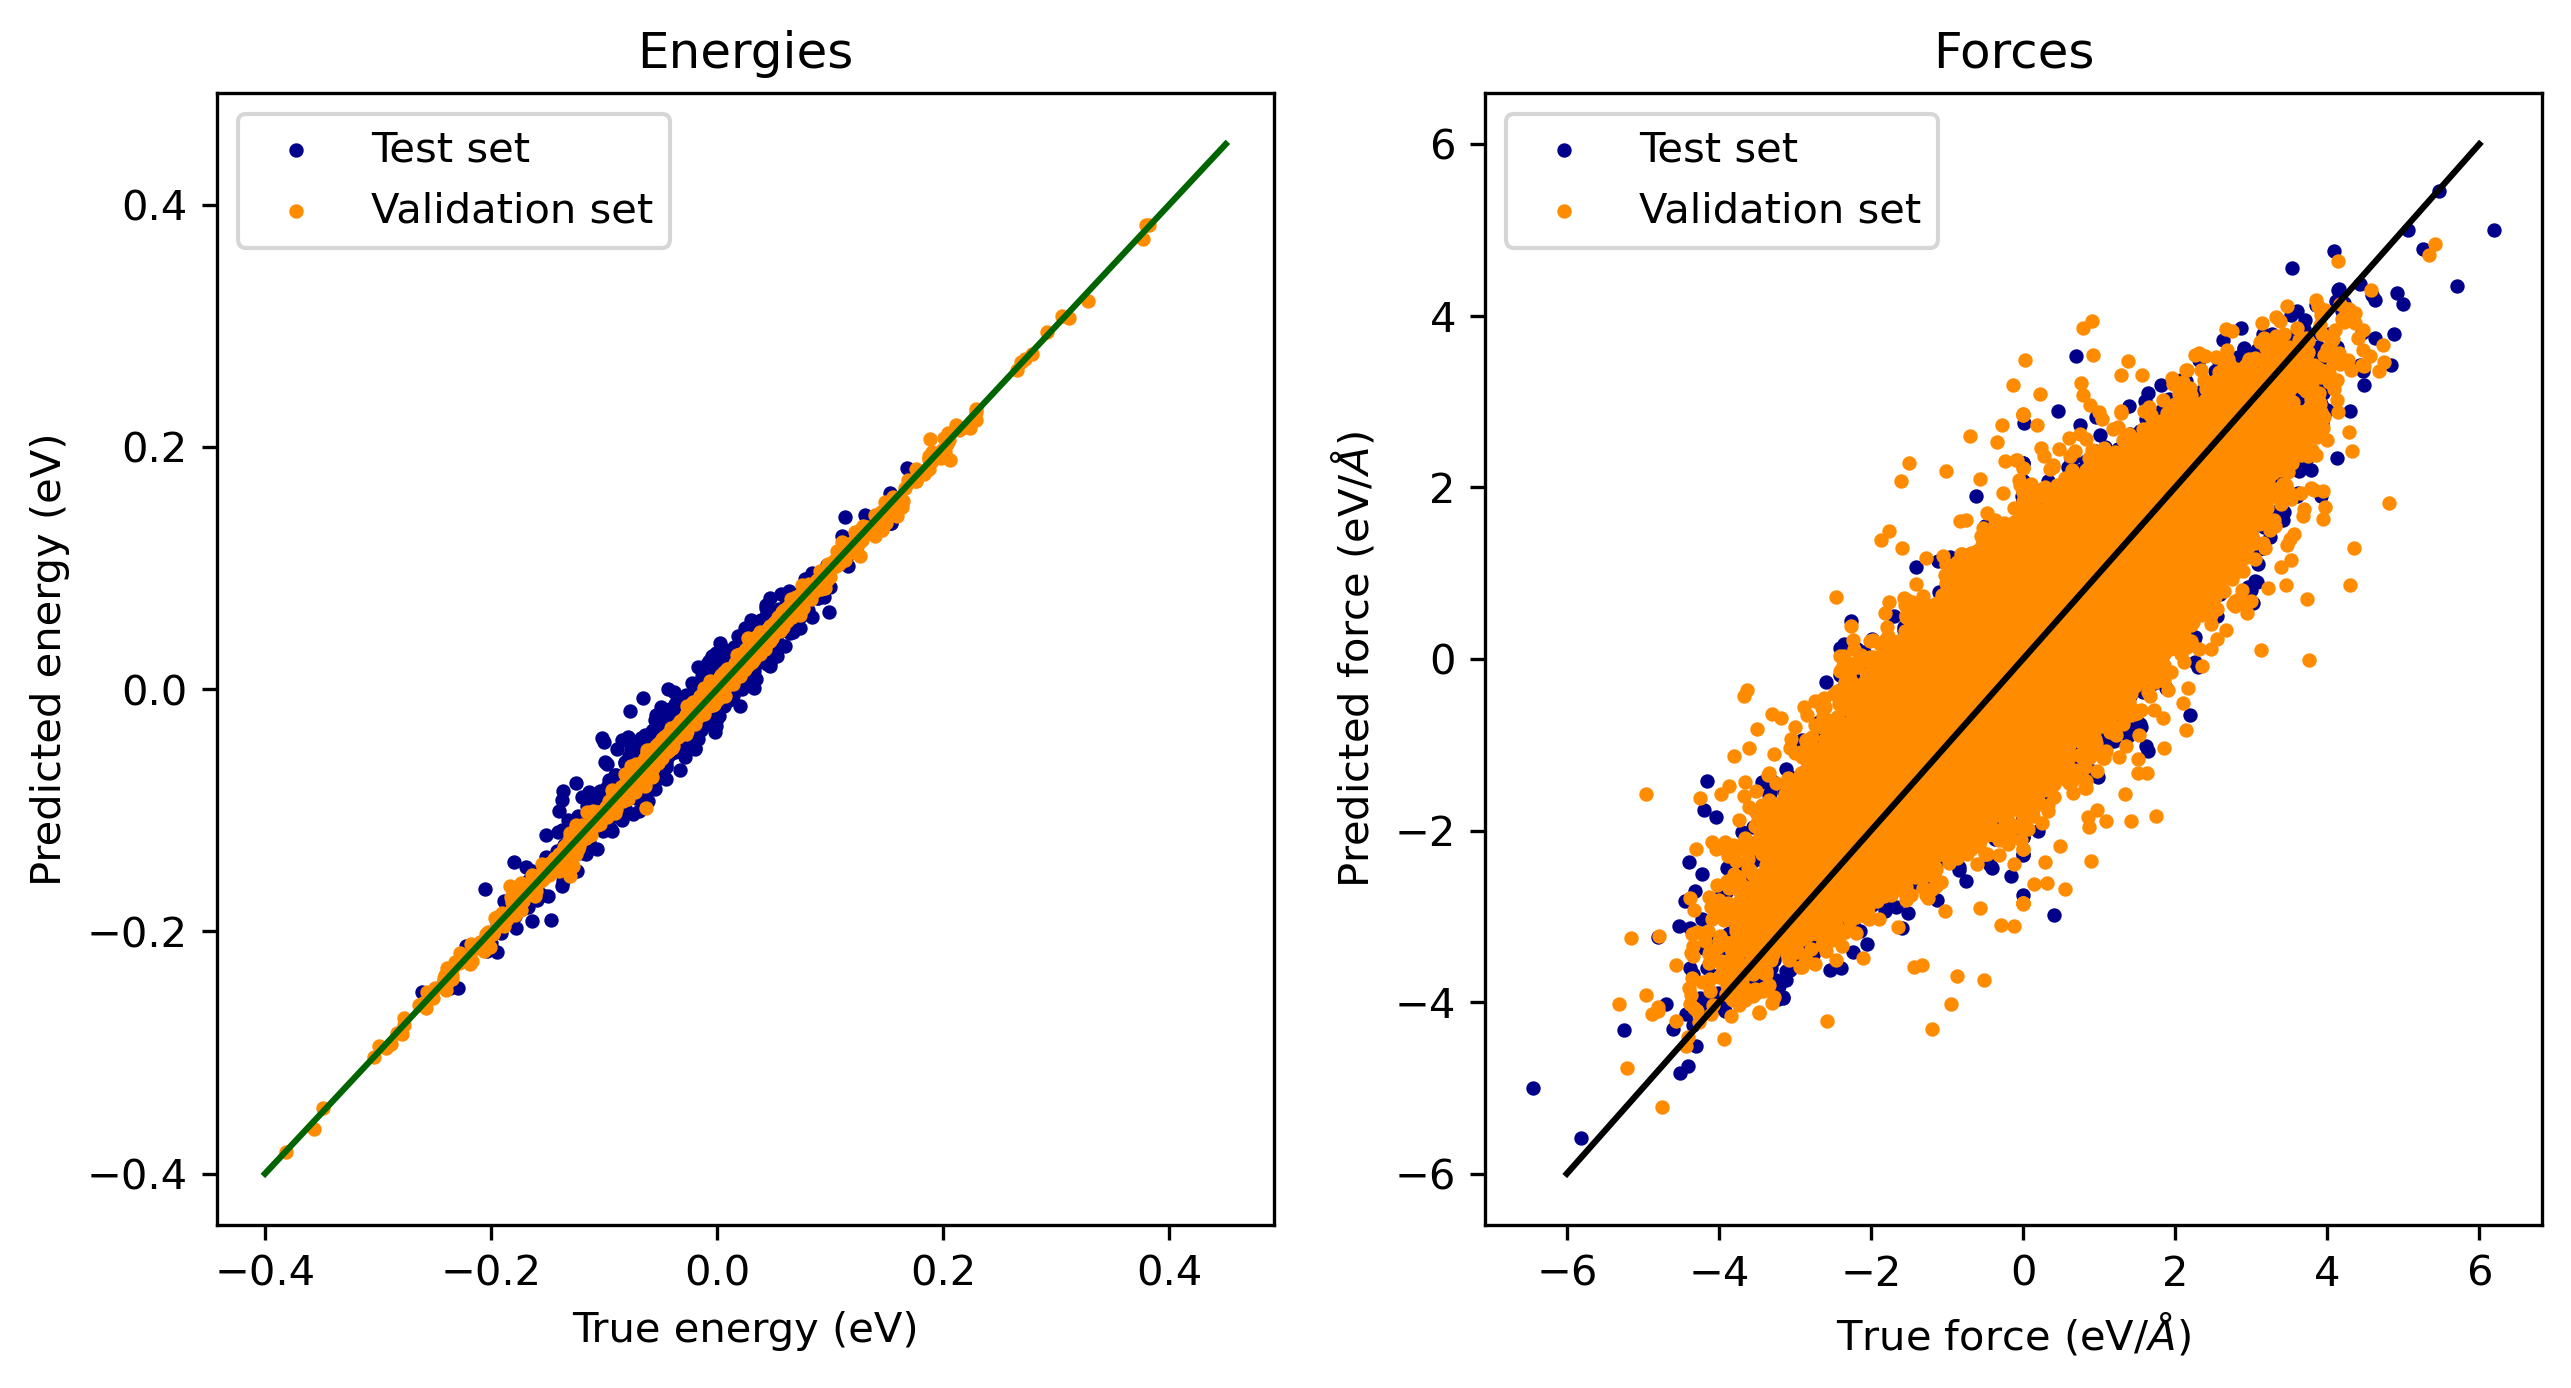

In [94]:
#Plot predicted vs. actual energies and forces
f,p = plt.subplots(1,2, figsize = (10, 5), dpi=300)
p[0].scatter((y_test[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1),
             (ytest_pred[:npred] - mlr.predict(X_test[:npred]))/np.sum(X_test[:npred],axis=1), 
             s=6, color='darkblue', alpha=1, label='Test set')
p[0].scatter((y_val[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1),
             (yval_pred[:npred] - mlr.predict(X_val[:npred]))/np.sum(X_val[:npred],axis=1), 
             s=6, color='darkorange', alpha=1, label='Validation set')
p[0].set_title('Energies')
p[0].plot([-0.4,0.45], [-0.4, 0.45], color='darkgreen')
p[0].set_xlabel('True energy (eV)')
p[0].set_ylabel('Predicted energy (eV)')
p[0].legend()
p[1].scatter(f_test.flatten(), ftest_pred.flatten(), s=6, color='darkblue', alpha=1, label='Test set')
p[1].scatter(f_val.flatten(), fval_pred.flatten(), s=6, color='darkorange', alpha=1, label='Validation set')
p[1].plot([-6,6], [-6, 6], color='black')
p[1].set_title(r'Forces')
p[1].set_xlabel('True force (eV/$\AA$)')
p[1].set_ylabel('Predicted force (eV/$\AA$)')
p[1].legend()
plt.savefig('figures/direct_model_test_val_set_comparison_model_15k_d_params_0.02_2.png')

# Quickly check speed of delta model created

In [72]:
model = load_obj('delta_data/GAP_model_15k_0.02_2.json')

FileNotFoundError: [Errno 2] No such file or directory: '/exports/commonscratch/vprincip/general_potential/delta_data/GAP_model_15k_0.02_2.json'

In [73]:
#predict energies and forces for test set
npred=1000
bla1 = []
bla2 = []

start=time()
for frm in tqdm(csd_1k[:npred], desc = "Making predictions for true test set...", leave=False):
    manager_test = soap.transform(frm)
    bla1.append(model.predict(manager_test))
    bla2.append(model.predict_forces(manager_test))

print(time()-start)

Making predictions for true test set...:   0%|          | 0/1000 [00:00<?, ?it/s]

NameError: name 'model' is not defined

In [ ]:
#